In [2]:

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt


## Data Preprocessing and Exploration

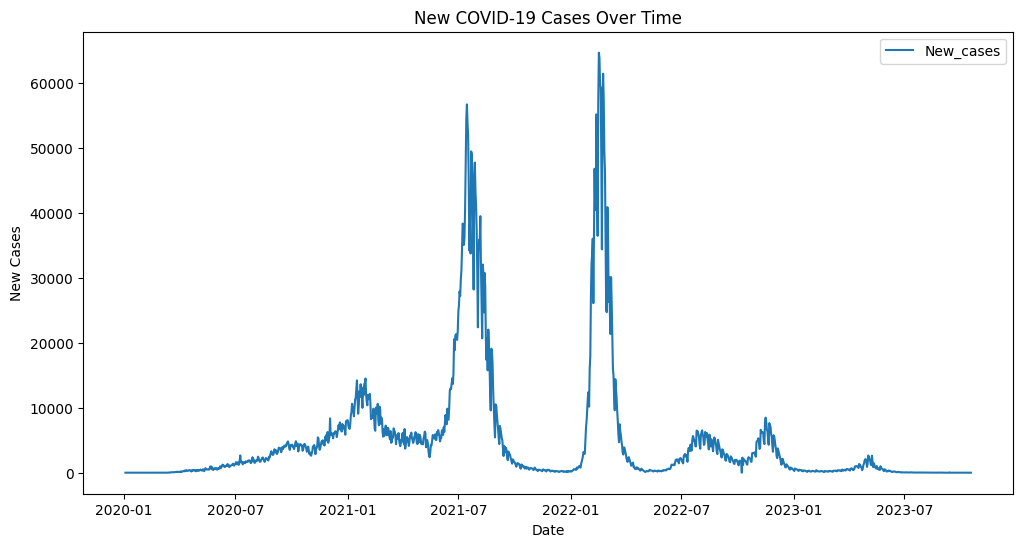

In [3]:

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('WHO-COVID-19-Indonesia-data.csv')
df['Date_reported'] = pd.to_datetime(df['Date_reported'])
df = df.sort_values('Date_reported')

# Plot the New_cases over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date_reported'], df['New_cases'], label='New_cases')
plt.title('New COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.show()


## 80-20 Data Splitting

In [4]:

# 80-20 split for initial validation
split_index = int(len(df) * 0.8)
train = df[:split_index]
validation = df[split_index:]


## Stationarity Test (ADF Test)

In [5]:

from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return result[1] <= 0.05  # p-value <= 0.05 means stationary

# Perform ADF test on 'New_cases' in the training set
is_stationary = adf_test(train['New_cases'])
is_stationary


True

Already stationary, skip differencing step. 
d = 0

## ACF and PACF Plots

<Figure size 1200x600 with 0 Axes>

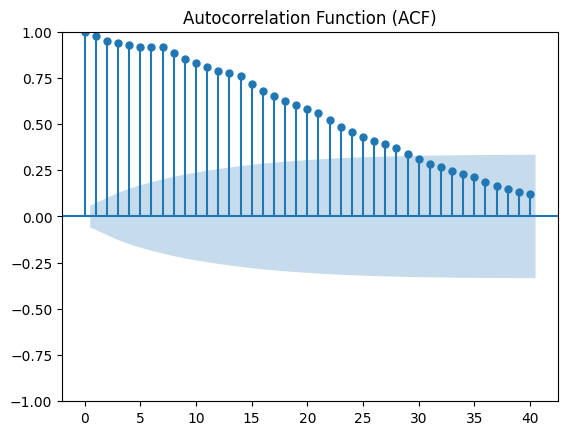

<Figure size 1200x600 with 0 Axes>

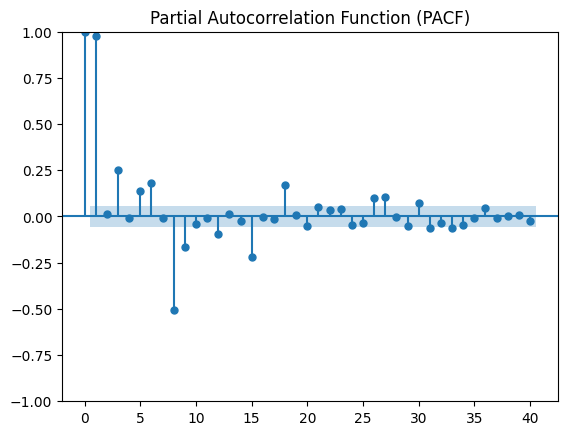

In [6]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(train['New_cases'], lags=40, title='Autocorrelation Function (ACF)')
plt.show()

# Plot Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(train['New_cases'], lags=40, title='Partial Autocorrelation Function (PACF)')
plt.show()



Based on the ACF and PACF plots, we can make the following observations:

- **ACF Plot**: The plot shows significant lags at the beginning. A typical choice for \( q \) in this situation could be 1 or 2.
- **PACF Plot**: The plot indicates that the first few lags are significant. A typical choice for \( p \) could be around 1 or 2.

So, based on the plots, a reasonable starting point could be \( p = 1 \) or \( p = 2 \) and \( q = 1 \) or \( q = 2 \).

Next, we can use the AIC test to determine the best combination of \( p \) and \( q \).


## AIC Test for Model Selection

In [9]:
# Initialize variables to store the best model parameters and AIC
import numpy as np
best_aic = np.inf
best_p = None
best_q = None
best_model = None

# Loop through combinations of p and q to find the best model based on AIC
for p in range(3):  # p = 0, 1, 2
    for q in range(3):  # q = 0, 1, 2
        try:
            model = ARIMA(train['New_cases'], order=(p, 0, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_p = p
                best_q = q
                best_model = model_fit
        except:
            continue

best_aic, best_p, best_q


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(20206.552303795434, 2, 2)

## 80-20 Split Validation

In [8]:
# Fit the ARIMA(2, 0, 2) model
model = ARIMA(train['New_cases'], order=(2, 0, 2))
model_fit = model.fit()

# Forecast on the validation set
forecast = model_fit.forecast(steps=len(validation))

# Calculate evaluation metrics for initial validation
mae_split = mean_absolute_error(validation['New_cases'], forecast)
rmse_split = sqrt(mean_squared_error(validation['New_cases'], forecast))

mae_split, rmse_split


(4190.920136312283, 4479.148655736016)

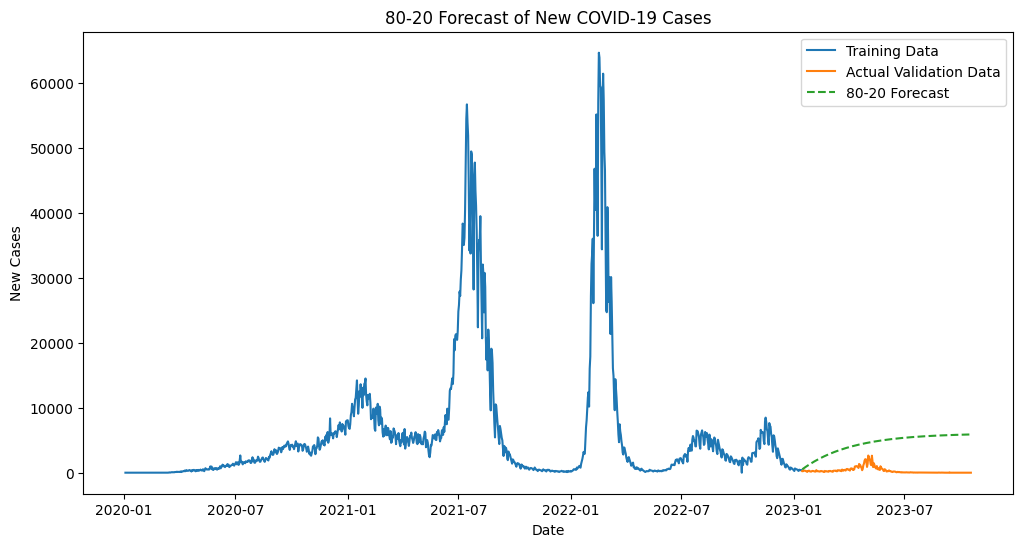

In [10]:

# Plot the 80-20 forecast
plt.figure(figsize=(12, 6))
plt.plot(train['Date_reported'], train['New_cases'], label='Training Data')
plt.plot(validation['Date_reported'], validation['New_cases'], label='Actual Validation Data')
plt.plot(validation['Date_reported'], forecast, label='80-20 Forecast', linestyle='--')
plt.title('80-20 Forecast of New COVID-19 Cases')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.show()


## Walk-Forward Validation

In [13]:

# Initialize lists to store the forecasts and actual values
forecasts = []
actuals = []

# Initialize the training data
train_data = df['New_cases'][:split_index].tolist()

# Perform walk-forward validation
for i in range(len(validation)):
    # Fit the ARIMA model
    model = ARIMA(train_data, order=(2, 0, 2))
    model_fit = model.fit()
    
    # Forecast the next value
    forecast = model_fit.forecast(steps=1)[0]
    forecasts.append(forecast)
    
    # Get the actual value
    actual = validation['New_cases'].iloc[i]
    actuals.append(actual)
    
    # Add the actual value to the training data for the next iteration
    train_data.append(actual)

# Calculate evaluation metrics for walk-forward validation
mae_walk_forward = mean_absolute_error(actuals, forecasts)
rmse_walk_forward = sqrt(mean_squared_error(actuals, forecasts))

mae_walk_forward, rmse_walk_forward


(137.3150752954842, 198.22851905851712)

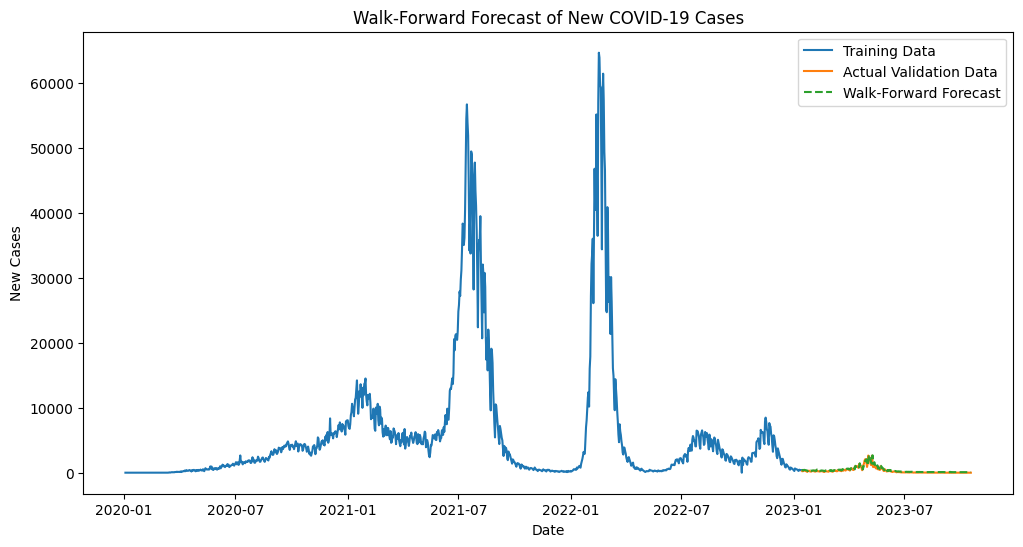

In [15]:

# Plot the walk-forward forecast
plt.figure(figsize=(12, 6))
plt.plot(train['Date_reported'], train['New_cases'], label='Training Data')
plt.plot(validation['Date_reported'], actuals, label='Actual Validation Data')
plt.plot(validation['Date_reported'], forecasts, label='Walk-Forward Forecast', linestyle='--')
plt.title('Walk-Forward Forecast of New COVID-19 Cases')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.show()


In [18]:
print('''

MAE 80-20: %f
RMSE 80-20: %f
      
MAE Walk-Forward: %f
RMSE Walk-Forward: %f   

       ''' % (mae_split, rmse_split, mae_walk_forward, rmse_walk_forward))



MAE 80-20: 4190.920136
RMSE 80-20: 4479.148656
      
MAE Walk-Forward: 137.315075
RMSE Walk-Forward: 198.228519   

       


## Garis Besar metode ARIMA
- Ambil data dari WHO
- Pembersihan data
- Pemisahan data: 80% data train dan 20% data test
- Cek stationary data train, kalau belum stationary lakukan tahap differencing. d = 0 karena sudah stationary
- PACF untuk inisialisasi nilai p AR
- ACF untuk inisialisasi nilai q MA
- Lakukan Grid Test dan Sort berdasarkan nilai AIC. cari AIC terendah untuk mencari nilai p dan q lebih optimal.
- Lakukan ujian dengan 80-20 kemudian evaluasi metriks
- Lakukan ujian dengan 80-20 walk forward kemudian evaluasi metriks

## Rumusan Masalah
1. Bagaimana kinerja model ARIMA dalam meramalkan kasus COVID-19 harian di Indonesia?
2. Bagaimana pengaruh teknik validasi yang berbeda, seperti pemisahan data 20-80 dan validasi berjalan ke depan, terhadap metrik evaluasi model ARIMA?
3. Teknik validasi mana yang memberikan peramalan paling dapat diandalkan untuk kasus COVID-19 harian di Indonesia?

## Kesimpulan

Menggunakan ARIMA untuk meramalkan kasus COVID-19 harian di Indonesia kinerjanya sangat bagus karena hasil MAE dan RMSE menunjukkan angka rendah terlebih menggunakan validasi berjalan ke depan. Pengaruh pemilihan teknis validasi sangat signifikan terhadap model ARIMA, perbedaan MAE dan RSME antara split 80-20 dengan berjalan ke depan sangat jauh. Dalam penelitian ini, ARIMA dengan menggunakan validasi berjalan ke depan sangat bisa di andalkan untuk kasus COVID-19 harian di Indonesia.